In [41]:
import pandas as pd
from models import AR_Net, AR, AR_Net_multi, AR_multi
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"

import matplotlib.pyplot as plt

df = pd.read_csv('data/charging_session_count_30.csv', index_col=0, parse_dates=['Period'])
df.head()

,BRYANT,CAMBRIDGE,HAMILTON,HIGH,MPL,RINCONADA,TED,WEBSTER
Period,,,,,,,,
2011-07-29 20:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2011-07-29 20:30:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2011-07-29 21:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2011-07-29 21:30:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2011-07-29 22:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [42]:
## Add info on day and hour
def add_covariates(dataf):
    dataf['Period'] = dataf.index.values
    dataf['Day'] = dataf['Period'].dt.dayofweek
    dataf['Hour'] = dataf['Period'].dt.hour

    ## shift to have info of day and hour at time t (and not t-1 as for sessions) when predicting t
    dataf['Day'] = dataf['Day'].shift(-1, fill_value = 6)
    dataf['Hour'] = dataf['Hour'].shift(-1, fill_value = 14)

    dataf = dataf.drop(columns = ['Period'])

    return dataf

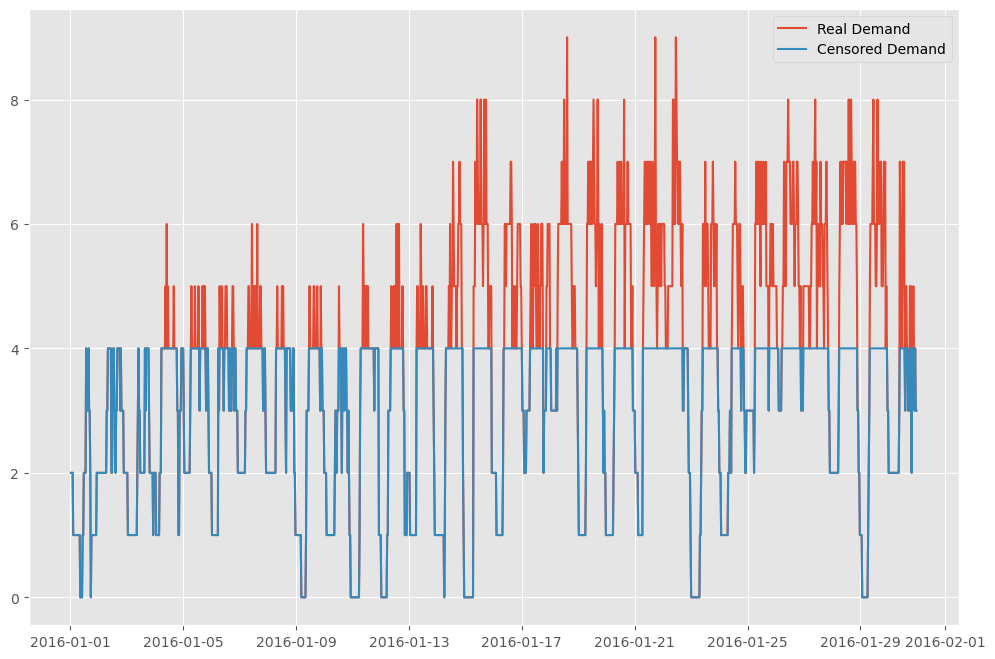

In [43]:
df = add_covariates(df)
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 8))
df_sample = add_covariates(df)
#df_sample = df.WEBSTER[((df.index > '2016-01-01') & (df.index < '2016-01-31'))].copy()

df_sample = df[['WEBSTER','Day', 'Hour']][((df.index > '2016-01-01') & (df.index < '2016-01-31'))].copy()
df_sample = df_sample.rename(columns = {'WEBSTER': 'Sessions'}).reset_index()
df_sample['Censored'] = df_sample['Sessions'].values

df_sample.loc[df_sample.Sessions > 4, 'Censored'] = 4
df_sample.reset_index(drop=True, inplace=True)
plt.plot(df_sample.Period, df_sample.Sessions, label='Real Demand')
plt.plot(df_sample.Period, df_sample.Censored, label='Censored Demand')
plt.legend()
plt.show()

In [44]:
import torch.nn as nn
import torch
import numpy as np


In [45]:
input_dim = 48*7
output_dim = 48
hidden_dim = 100

In [46]:
def train_batch(model, x, y, optimizer, loss_fn):
    # Run forward calculation
    y_predict = model.forward(x)
    # Compute loss.
    loss = loss_fn(y_predict, y)

    optimizer.zero_grad()

    loss.backward(retain_graph=True)

    optimizer.step()

    # Calculate MSE and report it
    mse = nn.functional.mse_loss(y_predict, y)

    return mse.data.item()


In [47]:
def poisson_negative_log_likelihood(y_predict, y):
    """ https://en.wikipedia.org/wiki/Poisson_regression#Maximum_likelihood-based_parameter_estimation """
    return -torch.sum(y*y_predict - torch.exp(y_predict))

In [48]:
def train_predict_ar(model, optimizer, loss_fn, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        loss_sum = 0
        for i in range((len(df_sample)-input_dim)//output_dim):
            X_train = torch.tensor(df_sample.iloc[output_dim*i: input_dim + output_dim * i].Sessions.values, dtype=torch.float32).view(1, -1)
            y_train = torch.tensor(df_sample.iloc[output_dim*i + input_dim: output_dim*(1+i) + input_dim].Sessions.values, dtype=torch.float32).view(1, -1)
            loss_sum += train_batch(model, X_train, y_train, optimizer, loss_fn)
        losses.append(loss_sum/epochs)
        if (epoch % 50 == 0 ):
            print(f'Epoch: {epoch} Loss: {np.mean(losses)}')

    PREDICT_DAYS = 22
    periods = []
    predictions = []

    model.eval()
    for days in range(PREDICT_DAYS):
        # make prediction
        X = df_sample.reset_index(drop=True).iloc[output_dim*days: input_dim + output_dim * days]
        y = df_sample.reset_index(drop=True).iloc[output_dim*days + input_dim: output_dim*(1+days) + input_dim]
        y_predict = model.forward(torch.tensor(X.Sessions.values, dtype=torch.float32).view(1, -1))
        y_predict = y_predict.detach().numpy().reshape(-1)
        predictions = predictions + list(y_predict)
        periods = periods + list(y.Period.values)

    return model, periods, predictions, losses

AR model created with input_dim:  336  and output_dim:  48
Epoch: 0 Loss: 7.211191940307617
Epoch: 50 Loss: 4.569605001449585
Epoch: 100 Loss: 3.9825633417733823
Epoch: 150 Loss: 3.2264223340994476
Epoch: 200 Loss: 3.104715371542309


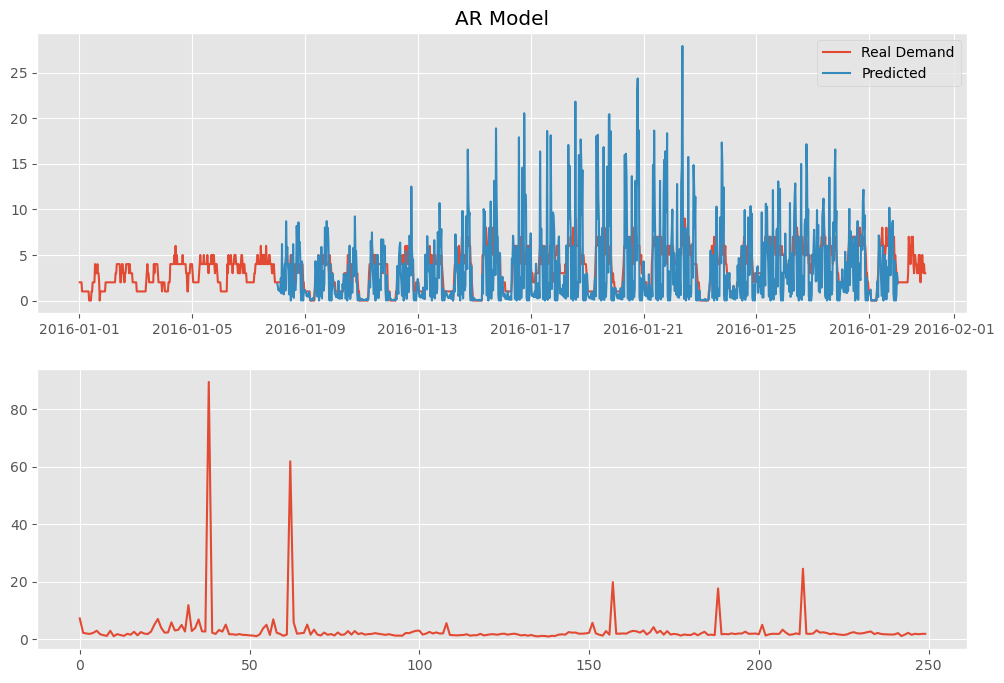

In [49]:
epochs = 250
model = AR(input_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.PoissonNLLLoss(log_input=False)#poisson_negative_log_likelihood

model, periods, predictions, losses = train_predict_ar(model, optimizer, loss_fn, epochs)

fig, ax = plt.subplots(2, figsize=(12, 8))

ax[0].plot(df_sample.Period, df_sample.Sessions.values, label='Real Demand')
ax[0].plot(periods, predictions, label='Predicted')
ax[0].set_title('AR Model')
ax[0].legend()

ax[1].plot(losses)
plt.show()

Epoch: 0 Loss: 0.6108837261199951
Epoch: 50 Loss: 0.2398884653133505
Epoch: 100 Loss: 0.17218174450704365
Epoch: 150 Loss: 0.1431181416499694
Epoch: 200 Loss: 0.12424051553811599


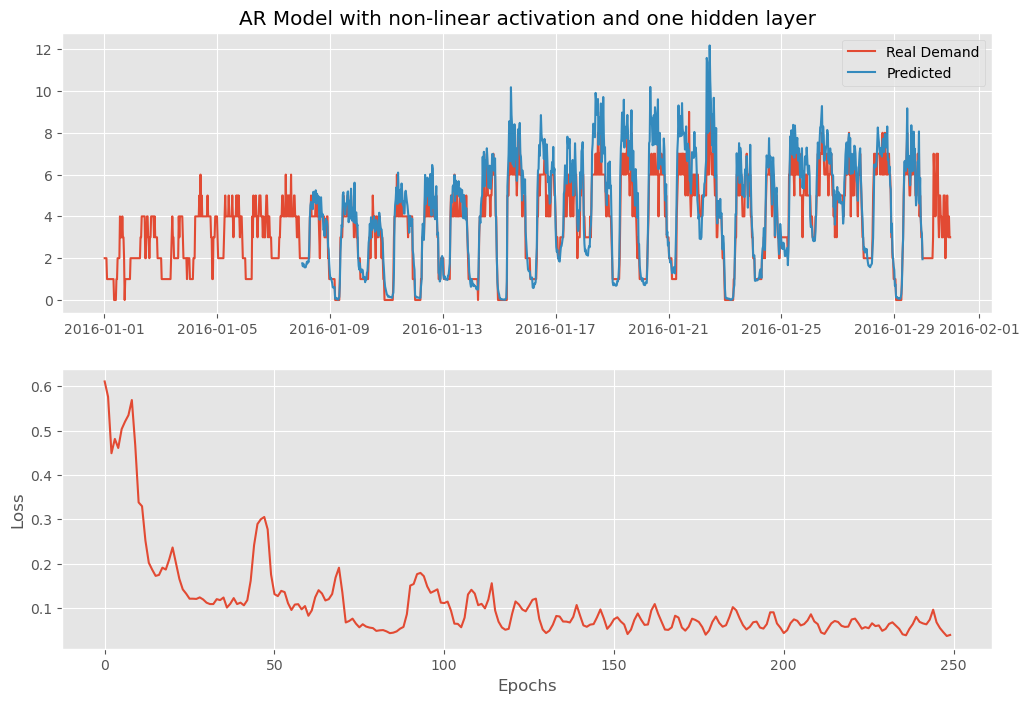

In [50]:
epochs = 250
model = AR_Net(input_dim, output_dim, 256)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.PoissonNLLLoss(log_input=False)#poisson_negative_log_likelihood
losses = []

model, periods, predictions, losses = train_predict_ar(model, optimizer, loss_fn, epochs)


fig, ax = plt.subplots(2, figsize=(12, 8))

ax[0].plot(df_sample.Period, df_sample.Sessions.values, label='Real Demand')
ax[0].plot(periods, predictions, label='Predicted')
ax[0].set_title('AR Model with non-linear activation and one hidden layer')
ax[0].legend()

ax[1].plot(losses)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
plt.show()

## Predicing using covariates (hour and week variable) at time t 

In [51]:
input_dim = 48*7

no_input_param = 3
output_dim = 48
hidden_dim = 100

In [52]:
df_sample.Sessions.values

array([2., 2., 2., ..., 4., 3., 3.])

Epoch: 0 Loss: 4.033560249328613


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning:

Using a target size (torch.Size([1, 48])) that is different to the input size (torch.Size([3, 48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/var/folders/yl/b9_wj9rx061bz1tpzkk98g440000gn/T/ipykernel_63357/3107346339.py:14: UserWarning:

Using a target size (torch.Size([1, 48])) that is different to the input size (torch.Size([3, 48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning:

Using a target size (torch.Size([1, 48])) that is different to the input size (torch.Size([3, 48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/var/folders/yl/b9_wj9rx061bz1tpzkk98g440000gn/T/ipykernel_63357/310

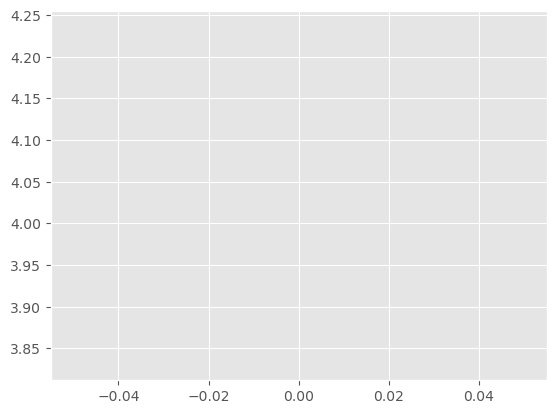

In [53]:
epochs = 250
model = AR_Net_multi(input_dim, output_dim, 256)
optimizer = torch.optim.Adam(model.parameters(), lr=0.008)
#loss_fn = poisson_negative_log_likelihood
loss_fn = nn.MSELoss()
losses = []
model.train()
for epoch in range(epochs):
    loss_sum = 0
    for i in range((len(df_sample)-input_dim)//output_dim):
        X_train = torch.tensor(df_sample.iloc[output_dim*i: input_dim + output_dim * i][['Sessions','Day', 'Hour']].values, dtype=torch.float32).reshape((no_input_param,input_dim))
        y_train = torch.tensor(df_sample.iloc[output_dim*i + input_dim: output_dim*(1+i) + input_dim].Sessions.values, dtype=torch.float32).view(1, -1)
        loss_sum += train_batch(model, X_train, y_train, optimizer, loss_fn)
        
    losses.append(loss_sum/epochs)

    if (epoch % 50 == 0 ):
        print(f'Epoch: {epoch} Loss: {np.mean(losses)}')
    break
plt.plot(losses)
plt.show()

In [54]:
# make prediction
X_eval = df_sample.reset_index(drop=True).iloc[:input_dim]
y_eval = df_sample.reset_index(drop=True).iloc[input_dim:input_dim + output_dim]

model.eval()
y_predict = model.forward(torch.tensor(X_eval.Sessions.values, dtype=torch.float32).view(1, -1))
y_predict = y_predict.detach().numpy().reshape(-1)

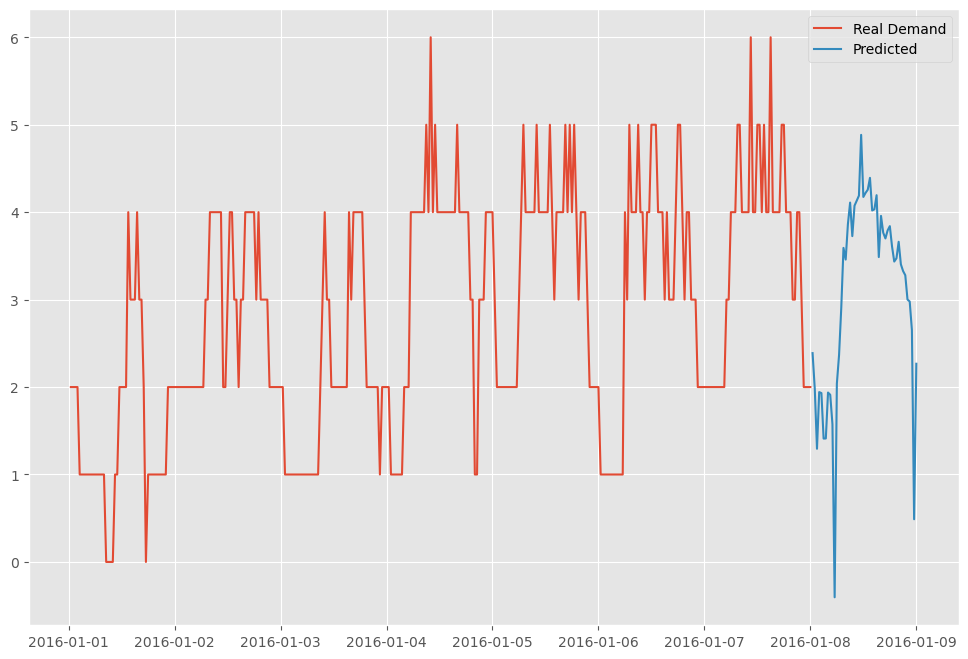

In [55]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(X_eval.Period, X_eval.Sessions.values, label='Real Demand')
#ax.plot(y_eval.Period, np.exp(y_predict), label='Predicted')
ax.plot(y_eval.Period, y_predict, label='Predicted')
plt.legend()

## LSTM multivariate

In [56]:
import torch.nn as nn
import torch
import numpy as np

import pandas as pd
from models import AR_Net
from models import AR_Net_multi

import matplotlib.pyplot as plt

def add_covariates(dataf):
    dataf['Period'] = dataf.index.values
    dataf['Day'] = dataf['Period'].dt.dayofweek
    dataf['Hour'] = dataf['Period'].dt.hour

    ## shift to have info of day and hour at time t (and not t-1 as for sessions) when predicting t
    dataf['Day'] = dataf['Day'].shift(-1, fill_value = 6)
    dataf['Hour'] = dataf['Hour'].shift(-1, fill_value = 14)

    dataf = dataf.drop(columns = ['Period'])

    return dataf

input_dim = 48*7
output_dim = 48
hidden_dim = 100


df = pd.read_csv('data/charging_session_count_30.csv', index_col=0, parse_dates=['Period'])
df.head()
df = add_covariates(df)

In [57]:
##  Create target variable 
target_var = "WEBSTER"
features = [target_var, "Day", "Hour"]
#features = list(df.columns.difference(['BRYANT', 'CAMBRIDGE', 'HAMILTON', 'HIGH', 'MPL', 'RINCONADA', 'TED']))

#features = list(df.columns.difference([target_var]))
forecast_lead = 24
target = f"{target_var}_lead{forecast_lead}"

df[target] = df[target_var].shift(-forecast_lead)
df = df.iloc[:-forecast_lead]

In [58]:
## Create train/test set
train_start = '2016-07-01'
test_start = '2016-07-31'
test_end = '2016-08-7'

df_train = df.loc[train_start:test_start].copy()
df_test = df.loc[test_start:test_end].copy()

print("Test set fraction:", len(df_test) / len(df_train))

Test set fraction: 0.25806451612903225


In [59]:
## Standardizing
"""
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev
"""

'\ntarget_mean = df_train[target].mean()\ntarget_stdev = df_train[target].std()\n\nfor c in df_train.columns:\n    mean = df_train[c].mean()\n    stdev = df_train[c].std()\n\n    df_train[c] = (df_train[c] - mean) / stdev\n    df_test[c] = (df_test[c] - mean) / stdev\n'

In [60]:
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [61]:
### Creating data sets
torch.manual_seed(101)
from torch.utils.data import DataLoader

batch_size = 4
sequence_length = 72

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

print(X[1,11,:])
print(y[1])

Features shape: torch.Size([4, 72, 3])
Target shape: torch.Size([4])
tensor([ 6.,  2., 16.])
tensor(7.)


In [62]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")


In [63]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

## AR

In [64]:
train_dataset_ar = SequenceDataset(
    df_train,
    target=target,
    features=['WEBSTER'],
    sequence_length=sequence_length
)
test_dataset_ar = SequenceDataset(
    df_test,
    target=target,
    features=['WEBSTER'],
    sequence_length=sequence_length
)

train_loader_ar = DataLoader(train_dataset_ar, batch_size=batch_size, shuffle=True)
test_loader_ar = DataLoader(test_dataset_ar, batch_size=batch_size, shuffle=False)


model_ar = AR(sequence_length, 1)
loss_function = nn.PoissonNLLLoss(log_input=False)
optimizer = torch.optim.Adam(model_ar.parameters(), lr=0.001)

model_ar.train()
for ix_epoch in range(10):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader_ar, model_ar, loss_function, optimizer=optimizer)
    test_model(test_loader_ar, model_ar, loss_function)
    print()

AR model created with input_dim:  72  and output_dim:  1
Epoch 0
---------
Train loss: -1.0426515672275776
Test loss: -1.5711367305678625

Epoch 1
---------
Train loss: -1.3043184835383648
Test loss: -1.6131264402841528

Epoch 2
---------
Train loss: -1.3924933697387416
Test loss: -1.743082292067508

Epoch 3
---------
Train loss: -1.461051980213773
Test loss: -1.8204525435964267

Epoch 4
---------
Train loss: -1.4556557386512718
Test loss: -1.788883762434125

Epoch 5
---------
Train loss: -1.5228288106980823
Test loss: -1.7630021935328841

Epoch 6
---------
Train loss: -1.5434263266863362
Test loss: -1.7724897957717378

Epoch 7
---------
Train loss: -1.5656103432699238
Test loss: -1.5274754043202847

Epoch 8
---------
Train loss: -1.5629433633419134
Test loss: -1.8877067300491035

Epoch 9
---------
Train loss: -1.5947687671149289
Test loss: -1.9335852833464742



In [65]:
train_eval_loader_ar = DataLoader(train_dataset_ar, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast (AR)"
df_train[ystar_col] = predict(train_eval_loader_ar, model_ar).numpy()
df_test[ystar_col] = predict(test_loader_ar, model_ar).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

In [66]:
plot_template = dict(
    layout=go.Layout({
        "font_size": 12,
        "xaxis_title_font_size": 14,
        "yaxis_title_font_size": 14})
)

fig = px.line(df_out[100:], labels=dict(created_at="Date", value="Sessions"))
fig.add_vline(x=test_start, line_width=4, line_dash="dash")
fig.add_annotation(xref="paper", x=0.75, yref="paper", y=1.02, text="Test set start", showarrow=False)
fig.update_layout(
    template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()

In [81]:
model_ar_net = AR_Net(sequence_length, 1, 100)
loss_function = nn.PoissonNLLLoss(log_input=False)
optimizer = torch.optim.Adam(model_ar_net.parameters(), lr=0.001)

model_ar_net.train()
for ix_epoch in range(50):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader_ar, model_ar_net, loss_function, optimizer=optimizer)
    test_model(test_loader_ar, model_ar_net, loss_function)

Epoch 0
---------
Train loss: -1.4673560067650773
Test loss: -1.8276210745486121
Epoch 1
---------
Train loss: -1.5817961834010579
Test loss: -1.8334239252532523
Epoch 2
---------
Train loss: -1.5995897031839816
Test loss: -1.886578972528999
Epoch 3
---------
Train loss: -1.6092450137059855
Test loss: -1.8798305752376716
Epoch 4
---------
Train loss: -1.6276594686211758
Test loss: -1.9434543006742995
Epoch 5
---------
Train loss: -1.6392789447019178
Test loss: -1.9370067683048546
Epoch 6
---------
Train loss: -1.6472990542890564
Test loss: -1.8823340442031622
Epoch 7
---------
Train loss: -1.6512046282890664
Test loss: -1.9407803192734718
Epoch 8
---------
Train loss: -1.6531348068627618
Test loss: -1.9247955372557044
Epoch 9
---------
Train loss: -1.6594885439481786
Test loss: -1.9427855098620057
Epoch 10
---------
Train loss: -1.6508598952123554
Test loss: -1.9231763581434886
Epoch 11
---------
Train loss: -1.6608898361684175
Test loss: -1.9335804800502956
Epoch 12
---------
Train lo

In [82]:
train_eval_loader_ar = DataLoader(train_dataset_ar, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast (AR-Net)"
model_ar_net.eval()
df_train[ystar_col] = predict(train_eval_loader_ar, model_ar_net).numpy()
df_test[ystar_col] = predict(test_loader_ar, model_ar_net).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]
plot_template = dict(
    layout=go.Layout({
        "font_size": 12,
        "xaxis_title_font_size": 14,
        "yaxis_title_font_size": 14})
)

fig = px.line(df_out[100:], labels=dict(created_at="Date", value="Sessions"))
fig.add_vline(x=test_start, line_width=4, line_dash="dash")
fig.add_annotation(xref="paper", x=0.75, yref="paper", y=1.02, text="Test set start", showarrow=False)
fig.update_layout(
    template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()

In [67]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)
        
        #self.activation = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.
        #out = self.activation(out)

        #return out.exp()

        return out

In [68]:
learning_rate = 5e-4
num_hidden_units = 16

def poisson_negative_log_likelihood(y_predict, y):
    """ https://en.wikipedia.org/wiki/Poisson_regression#Maximum_likelihood-based_parameter_estimation """
    return -torch.sum(y*y_predict - torch.exp(y_predict))
    y_pred - y_true * log(y_pred)

def poisson(y_predict, y):
    """ https://github.com/keras-team/keras/blob/v2.11.0/keras/losses.py#L2404-L2437 """
    return torch.mean(y_predict - y * torch.log(y_predict)) ##-torch.sum(-y_predict + y*torch.log2(y_predict+1e-8))


model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
#loss_function = poisson
#loss_function = nn.PoissonNLLLoss(log_input = False)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [69]:
for ix_epoch in range(2):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()

Epoch 0
---------
Train loss: 10.97235216568875
Test loss: 4.852455603114019

Epoch 1
---------
Train loss: 4.582330054733702
Test loss: 4.2909279704811825



In [70]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]
"""
for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean
"""

'\nfor c in df_out.columns:\n    df_out[c] = df_out[c] * target_stdev + target_mean\n'

In [71]:
df_out.min()

WEBSTER_lead24    0.000000
Model forecast    3.843417
dtype: float64

In [72]:
plot_template = dict(
    layout=go.Layout({
        "font_size": 12,
        "xaxis_title_font_size": 14,
        "yaxis_title_font_size": 14})
)

fig = px.line(df_out[100:], labels=dict(created_at="Date", value="Sessions"))
fig.add_vline(x=test_start, line_width=4, line_dash="dash")
fig.add_annotation(xref="paper", x=0.75, yref="paper", y=1.02, text="Test set start", showarrow=False)
fig.update_layout(
    template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()

[]

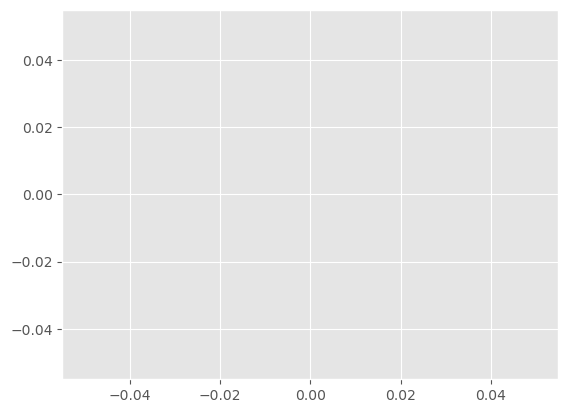

In [73]:
fig, ax = plt.subplots()
ax.plot()

## MISC

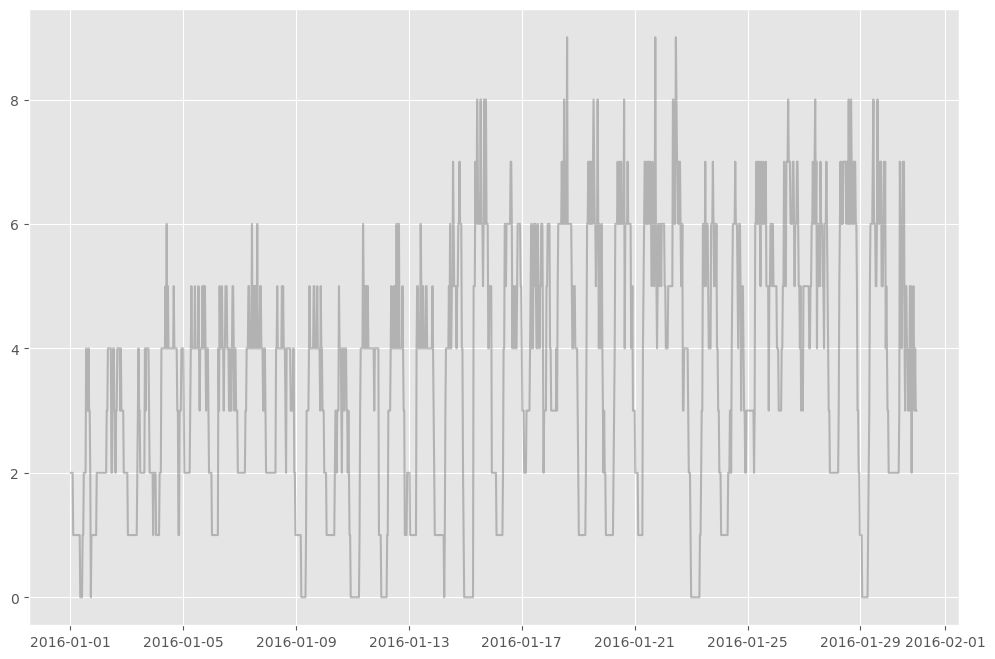

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [74]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(df_sample.Period, df_sample.Sessions.values, label='Real Demand', color='grey', alpha=0.5)
plt.show()
for i in range((len(df_sample)-input_dim)//output_dim):
   X_train = df_sample.iloc[output_dim*i: input_dim + output_dim * i]
   y_train = df_sample.iloc[output_dim*i + input_dim: output_dim*(1+i) + input_dim]
   line1, = ax.plot(X_train.Period, X_train.Sessions.values, label=f'{i}', color='red', alpha=0.5)
   line2, = ax.plot(y_train.Period, y_train.Sessions.values, label=f'{i}', color='green', alpha=0.5)

   plt.draw()
   plt.pause(1)
   line1.remove()
   line2.remove()